# Creating a Multi-Classification NN with Logisitic Regression

## Data Set
https://www.kaggle.com/datasets/mrsimple07/obesity-prediction

In [18]:
import pandas as pd
data = pd.read_csv("obesity_data.csv")

In [19]:
data.isnull().sum()

Age                      0
Gender                   0
Height                   0
Weight                   0
BMI                      0
PhysicalActivityLevel    0
ObesityCategory          0
dtype: int64

In [20]:
# Check for duplicate values
data.duplicated().sum()

0

In [21]:
data.describe()

,Age,Height,Weight,BMI,PhysicalActivityLevel
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,49.857000,170.052417,71.205769,24.888317,2.534000
std,18.114267,10.309971,15.509849,6.193912,1.116284
min,18.000000,136.115719,26.065730,8.470572,1.000000
25%,35.000000,163.514205,61.129629,20.918068,2.000000
50%,50.000000,169.801665,71.929072,24.698647,3.000000
75%,66.000000,177.353596,81.133746,28.732132,4.000000
max,79.000000,201.419670,118.907366,50.791898,4.000000


Our data does not contain any errors. Now we need to make sure the data is unbiased.

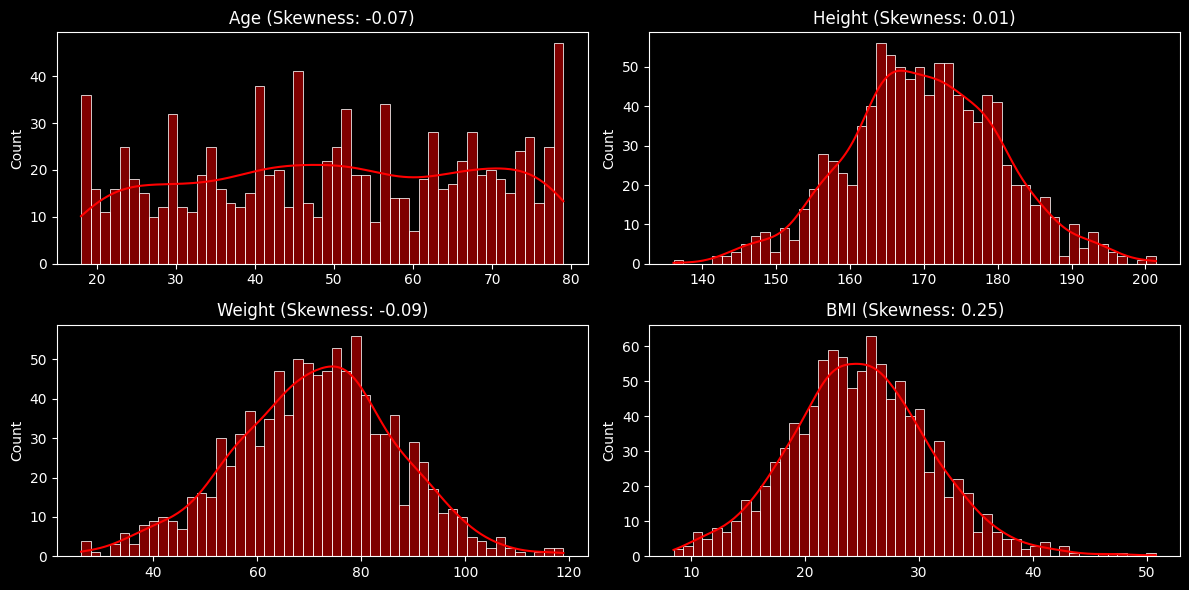

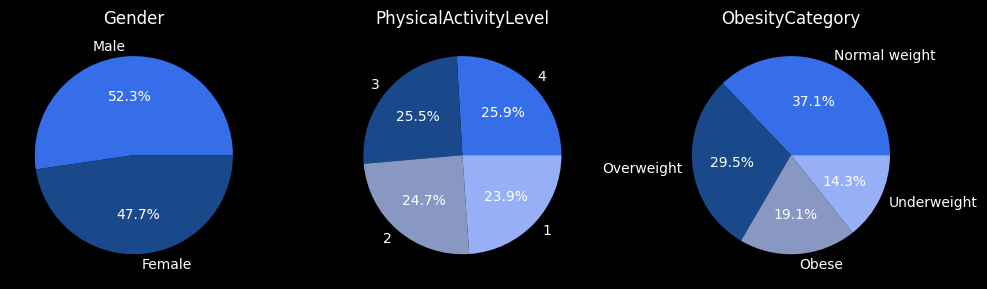

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

categories = ["Age","Height","Weight","BMI"]
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
for i, ax in zip(categories, axes.flat):
    sns.histplot(data[i], color="red", bins=50, kde=True, ax=ax)
    ax.set_title(f"{i} (Skewness: {data[i].skew().round(2)})")
    ax.set_xlabel("")
plt.style.use("dark_background")
plt.tight_layout()
plt.show()

categories = ["Gender", "PhysicalActivityLevel", "ObesityCategory"]
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
for i, ax in zip(categories, axes.flat):
    ax.set_title(f"{i}")
    ax.pie(data[i].value_counts().values, labels=data[i].value_counts().index, colors=['#366EEA','#19498A','#8898C3','#97AFF7'], autopct='%1.1f%%')
plt.style.use("dark_background")
plt.tight_layout()
plt.show()


Our data appears to be unbiased

## Data Preparation

The data contains 1000 samples with 7 features. However, some features are strings while others are floats 

In [23]:
import numpy as np
data = np.array(data)
m,n = data.shape

data[data == "Male"] = 0
data[data == "Female"] = 1
data[data == "Underweight"] = 0
data[data == "Normal weight"] = 1
data[data == "Overweight"] = 2
data[data == "Obese"] = 3

Each feature has their own "scale". For example BMI values range from 8.5 to 50.8 while Height ranges from 136 to 201 cm. Feature scaling provides many benefits such as:

1. Prevents a feature with a larger scale to dominate the weight adjustments
2. Prevents overflows 
3. Helps gradient descent to converge faster

In [24]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_data = data[:, :-1]
X_data = X_data.astype(float)
X_data = scaler.fit_transform(X_data)
X_train = X_data[:800, :]
X_test = X_data[800:960, :]
X_validation = X_data[960:1000, :]

Y_data = data[:, -1]
Y_data = Y_data.astype(int)
Y_train = Y_data[:800]
Y_test = Y_data[800:960]
Y_validation = Y_data[960:1000]

## One Vs All One Hot Encoding
When training a Multi-classification model there are generally two methods to encode multiple classes into binary- OVA(One Vs. All) and OVR(One Vs. Rest). I will be using OVA.

In [25]:
def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max()+1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    return one_hot_Y


Y_train_one_hot = one_hot(Y_train)
Y_test_one_hot = one_hot(Y_test)
Y_validation_one_hot = one_hot(Y_validation)

## Layer Classes

All of the layers will be Fully Connected(Dense).I will be using RELU for the hidden layers and Softmax for the output layer to convert the output to probability vectors

In [26]:
class relu:
    def forward(self, X):
        return np.maximum(0, X)

    def backward(self, Z):
        return np.where(Z <= 0, 0, 1)


class Softmax:
    def forward(self, X):
        #prevent numerical overflow
        X_max = np.max(X, axis=1, keepdims=True)
        X_shifted = X - X_max
        expX = np.exp(X_shifted)
        return expX / np.sum(expX, axis=1, keepdims=True)

    def backward(self, A):
        return A*(1-A)


class Dense_Layer:
    def __init__(self, n_x, n_y):
        self.W = np.random.rand(n_x, n_y) - 0.5
        self.b = np.zeros((1, n_y))

    def forward(self, X):
        Z = np.dot(X, self.W) + self.b
        return Z

## Model

I will be using L2 and inverted dropout regularization due to overfitting because of the dataset is small. Additionally, I will include early stopping to prevent unnecessary computation

Note:
To split the class methods into separate cells for readability i defined a function that adds class methods through a decorator

In [27]:
class Model:
    def __init__(self, lr, dropout_keep_rate, l2_reg):
        self.layers = []
        self.dropout_k_rate = dropout_keep_rate
        self.l2_reg = l2_reg
        self.lr = lr
    def add_layer(self, layer):
            self.layers.append(layer)
            return
def classMethod(func):
    setattr(Model, func.__name__, func)
    return func

Cross Entropy with l2 formula:
$$
C = -(\frac {1} {m}) \sum^{m}_{i=1} \sum^{n}_{j=1} y_{ij} \cdot log{\hat y_{ij}} + \lambda \sum^{m}_{i=1} W^2_i
$$
Where:
- $m$ = No. of samples
- $y$ = Ground truth
- $\hat y$ = Model prediction
- $\sum^{m}_{i=1}$ = Sum across the samples (row) of the matrix
- $\sum^{n}_{j=1}$ = Sum across the classes (cols) of the matrix 
- $\lambda$ = A hyperparameter that effects how much the weights are penalized
- $W$  = weight vector 

Note: <br>
$log = log_e$ <br>

In [28]:
@classMethod
def set_loss(self, loss_function):
        if (loss_function != "CELoss"):
            raise Exception("Unknown loss function")
        self.loss = loss_function
        return

@classMethod
def train_loss_forward(self, Y_pred, Y_true):
        lamb = self.l2_reg
        #NumPy sums across rows and cols by default and handles vector multiplication
        cost = -(1/m) * np.sum(Y_true * np.log(Y_pred))
        weights = self.weights
        w_squared_sum = 0
        for W in weights:
            w_squared_sum += np.sum(np.square(W))
        l2_cost = (lamb/(2*m))*w_squared_sum
        cost += l2_cost
        return cost

@classMethod
#cross validation loss does not use regularization
def valid_loss_forward(self, Y_pred, Y_true):
        cost = -(1/m) * np.sum(Y_true * np.log(Y_pred))
        return cost

### Forward Propagation
This is fairly simple
$$ 
Z^{(l)} = X^{(l-1)} \cdot W^{(l)} + b^{(l)}\\
A^{(l)} = Activation(Z^{(l)})\\
D^{(l)} = U(p)\\
A^{(l)} = (A^{(l)} \cdot D^{(l)})/p
$$
Where: 
- $ X^{(l-1)} $  is the input to the current layer (output of the previous layer or input data).
- $ W^{(l)} $ is the weight matrix of the current layer.
- $ b^{(l)} $ is the bias vector of the current layer.
- $ Z^{(l)} $ is the pre-activation value of the current layer.
- $ A^{(l)} $ is the Activation value (output) of the current layer.
- $D^{(l)}$ is the Dropout mask (deactivates neurons)
- $p$ is the probability of neurons that will be activated
- $U$ is the uniform distribution over [0,1) where p samples are 1s and the rest are 0

       



In [29]:
@classMethod
def train_forward(self, X):
    layer_input = X
    self.weights = []
    self.bias = []
    self.A_vals = [layer_input,]
    self.Z_vals = []
    self.D_masks = []
    self.act_prime = []
    keep_prob = self.dropout_k_rate
    for layer in self.layers:
        layer_input = layer.forward(layer_input)
        if isinstance(layer, Dense_Layer):
            self.weights.append(layer.W)
            self.bias.append(layer.b)
            self.Z_vals.append(layer_input)
        else:
            if isinstance(layer, Softmax) == False:
                D = np.random.rand(
                    layer_input.shape[0], layer_input.shape[1]) < keep_prob
                A = layer_input * D
                A = A / keep_prob
                self.A_vals.append(A)
                self.D_masks.append(D)
            else:
                self.A_vals.append(layer_input)
            self.act_prime.append(layer.backward)
    return layer_input

@classMethod
def valid_forward(self, X):
    layer_input = X
    self.weights = []
    for layer in self.layers:
        if isinstance(layer, Dense_Layer):
            self.weights.append(layer.W)
        layer_input = layer.forward(layer_input)
    return layer_input

### Backward Propagation

Note: I will not explicitly include dropout in the backpropagation formulas as it just updates A   


At the simplest level Backward Propagation is computing the partial derivative of the Loss function W.R.T every weight and bias matrix In general:
$$
\frac{\partial L }{\partial W^{(l)}} = \frac {\partial L} {\partial A^{(l)}} \frac {\partial A^{(l)}} {\partial Z^{(l)}} \frac {\partial Z^{(l)}} {\partial W^{(l)}} + \lambda  \frac {W^{(l)}} m
$$
$$
\frac{\partial L }{\partial b^{(l)}} = \frac {\partial L} {\partial A^{(l)}} \frac {\partial A^{(l)}} {\partial Z^{(l)}}\frac {\partial Z^{(l)}} {\partial b^{(l)}}
$$
And **assuming $l+1$ exists** 
$$
\frac {\partial L} {\partial A^{(l)}} = \frac {\partial L} {\partial A^{(l+1)}} \frac {\partial A^{(l+1)}} {\partial Z^{(l+1)}} \frac {\partial Z^{(l+1)}} {\partial A^{(l)}}
$$
$$
\frac {\partial L} {\partial A^{(l)}} \implies \frac {\partial L^{(l+1)}} {\partial Z^{(l+1)}}\frac {\partial Z^{(l+1)}} {\partial A^{(l)}}
$$

For example: 
$$
\frac{\partial L }{\partial W^{(4)}} =\frac {\partial L} {\partial A^{(4)}} \frac {\partial A^{(4)}} {\partial Z^{(4)}} \frac {\partial Z^{(4)}} {\partial W^{(4)}} + \lambda  \frac {W^{(4)}} m
$$

$\Large \frac {\partial L} {\partial A^{(4)}} \frac {\partial A^{(4)}} {\partial Z^{(4)}}$ can be simplified to $\frac {1} {m} \cdot (A^{(4)}-Y)$ <br>
The [proof](https://towardsdatascience.com/derivative-of-the-softmax-function-and-the-categorical-cross-entropy-loss-ffceefc081d1) only assumes one sample so it excludes $\sum^{m}_{j=1}$

$$
\frac {\partial Z^{(4)}} {\partial W^{(4)}} = \frac {\partial } {\partial W^{(4)}} [Z^{(4)} = A^{(3)} \cdot W^{(4)} + b^{(4)}]\\
= A^{(3)}
$$

$$
\frac{\partial L }{\partial W^{(4)}} \implies [\frac {1} {m} \cdot (A^{(4)}-Y)] \cdot A^{(3)} + \lambda  \frac {W^{(4)}} m
$$

And
$$
\frac{\partial L }{\partial b^{(4)}} =\frac {\partial L} {\partial A^{(4)}} \frac {\partial A^{(4)}} {\partial Z^{(4)}} \frac {\partial Z^{(4)}} {\partial b^{(4)}}
$$
$$
\frac {\partial Z^{(4)}} {\partial b^{(4)}} = \frac {\partial } {\partial b^{(4)}} [Z^{(4)} = A^{(3)} \cdot W^{(4)} + b^{(4)}]\\
= 1
$$
$$
\frac{\partial L }{\partial b^{(4)}} \implies \frac {1} {m} \cdot (A^{(4)}-Y)
$$


In [30]:
@classMethod
def backward(self, Y_true):
        if (self.loss == None):
            raise Exception("Loss function was not set")
        if (self.loss == "CELoss"):
            A_vals = self.A_vals
            W = self.weights
            Z_vals = self.Z_vals
            a_prime = self.act_prime
            lamb = self.l2_reg
            D_masks = self.D_masks
            self.weight_grads = []
            self.bias_grads = []
            dz = (1/m) * (A_vals[-1] - Y_true)
            dw = np.dot(A_vals[-2].T, dz)+(lamb*W[-1])/m
            db = np.sum(dz, axis=0, keepdims=True)
            self.weight_grads.append(dw)
            self.bias_grads.append(db)
            n_layers = len(A_vals) - 1
            for i in range(n_layers - 1, 0, -1):
                dz = np.dot(dz, W[i].T)
                dz = (dz * D_masks[i - 1]) / self.dropout_k_rate
                dz = dz * a_prime[i - 1](Z_vals[i - 1])
                dw = np.dot(A_vals[i - 1].T, dz) + (lamb * W[i - 1]) / m
                db = np.sum(dz, axis=0, keepdims=True)
                self.weight_grads.append(dw)
                self.bias_grads.append(db)
        return

### Gradient Descent

While backpropagation is the computation of the weight and bias gradients gradient descent is the actual updating of the values in the opposite direction of the gradient. This is straightfoward:

$$
W^{(l)} = lr \cdot \frac {\partial L} {\partial W^{(l)}}
$$
$$
b^{(l)} = lr \cdot \frac {\partial L} {\partial b^{(l)}}
$$
Where
- $lr$ = the learning rate 


In [31]:
@classMethod
def gradient_descent(self):
        lr = self.lr
        weights = self.weights
        weight_grads = self.weight_grads
        bias = self.bias
        bias_grads = self.bias_grads
        for w, w_grad, b, b_grad in zip(weights, reversed(weight_grads), bias, reversed(bias_grads)):
            w -= lr*w_grad
            b -= lr*b_grad
        idx = 0
        for i in range(len(self.layers)):
            if isinstance(self.layers[i], Dense_Layer):
                self.layers[i].W = weights[idx]
                self.layers[i].b = bias[idx]
                idx += 1

There are multitundious ways to implement early stopping. However, I chose to use the mean of the training cost as the metric of determination.

patience is a hyperparameter that compares the previous patience epochs to the current patience epochs

For example if patience was 50 it would compare the previous 50 epochs to the current 50 epochs

In [32]:
@classMethod
def predict(self, X):
        layer_input = X
        for layer in self.layers:
            layer_input = layer.forward(layer_input)
        return np.argmax(layer_input, axis=1)
@classMethod
def fit(self, epochs, patience=50):
    self.metrics = {
        "valid_costs": [],
        "train_costs": [],
        "valid_accuracies": [],
        "train_accuracies": [],
    }
    self.early_stop_epoch = epochs
    prev_mean_calc = None
    for i in range(epochs):
        A_valid = self.valid_forward(X_validation)
        self.metrics["valid_costs"].append(
            self.valid_loss_forward(A_valid, Y_validation_one_hot))

        A = self.train_forward(X_train)
        self.metrics["train_costs"].append(
            self.train_loss_forward(A, Y_train_one_hot))
        train_acc = np.sum(self.predict(X_train) == Y_train) / Y_train.size
        self.metrics["train_accuracies"].append(train_acc)
        valid_acc = np.sum(self.predict(X_validation) ==
                            Y_validation) / Y_validation.size
        self.metrics["valid_accuracies"].append(valid_acc)
        self.backward(Y_train_one_hot)
        self.gradient_descent()
        if (i > patience*2):
            if (prev_mean_calc == None):
                prev_mean_calc = np.mean(
                    self.metrics["valid_costs"][i-patience:i])
            curr_mean_calc = np.mean(
                self.metrics["valid_costs"][i-patience*2:i-patience])
            if (abs(prev_mean_calc-curr_mean_calc) < 1e-3):
                self.early_stop_epoch = i+1
                print(f"early stopped at epoch {i}")
                return
            prev_mean_calc = curr_mean_calc
        if (i % 100 == 0):
            print(f"cost {self.metrics['train_costs'][-1]}")
    return

When creating a multi-classification model there are many metrics of accuracy so we will define a method to create a graph to display them

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
@classMethod
def plot_metrics(self, Y_pred, Y_true):
    epochs = self.early_stop_epoch
    train_costs = self.metrics["train_costs"]
    val_costs = self.metrics["valid_costs"]
    val_accs = self.metrics["valid_accuracies"]
    train_accs = self.metrics["train_accuracies"]

    fig, axs = plt.subplots(2, 2, figsize=(12, 8))

    # Losses
    axs[0, 0].plot(range(epochs), train_costs, 
                    label=f'Training Loss (best: {np.round(min(train_costs),4)}',color = "red")
    axs[0, 0].plot(range(
        epochs), val_costs, label=f'Validation Loss (best: {np.round(min(val_costs),4)})',color = "blue")
    axs[0, 0].set_title('Losses')
    axs[0, 0].set_xlabel('Epochs')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].legend()

    # Accuracies
    axs[0, 1].plot(range(epochs), train_accs,
                    label=f'Training Accuracy (best: {max(train_accs)})',color = "red")
    axs[0, 1].plot(range(epochs), val_accs,
                    label=f'Validation Accuracy (best: {max(val_accs)})',color = "blue")
    axs[0, 1].set_title('Accuracies')
    axs[0, 1].set_xlabel('Epochs')
    axs[0, 1].set_ylabel('Accuracy')
    axs[0, 1].legend()

    # Confusion Matrix
    cm = confusion_matrix(Y_true, Y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues", ax=axs[1, 0])
    axs[1, 0].set_title('Confusion Matrix')

    # Metrics
    axs[1, 1].axis('off')
    axs[1, 1].text(
        0.1, 0.8, f"Recall: {recall_score(Y_true, Y_pred, average='macro'):.4f}", transform=axs[1, 1].transAxes)
    axs[1, 1].text(
        0.1, 0.6, f"Precision: {precision_score(Y_true, Y_pred, average='macro'):.4f}", transform=axs[1, 1].transAxes)
    axs[1, 1].text(
        0.1, 0.4, f"F1 Score: {f1_score(Y_true, Y_pred, average='macro'):.4f}", transform=axs[1, 1].transAxes)
    axs[1, 1].text(
        0.1, 0.2, f"Test Accuracy: {(np.sum(self.predict(X_test) == Y_test) / Y_test.size):.4f}", transform=axs[1, 1].transAxes)
    
  
    

    plt.style.use("dark_background")
    plt.tight_layout()
    plt.show()
    return

cost 8.30362984357497
cost 0.36164964869989336
early stopped at epoch 177


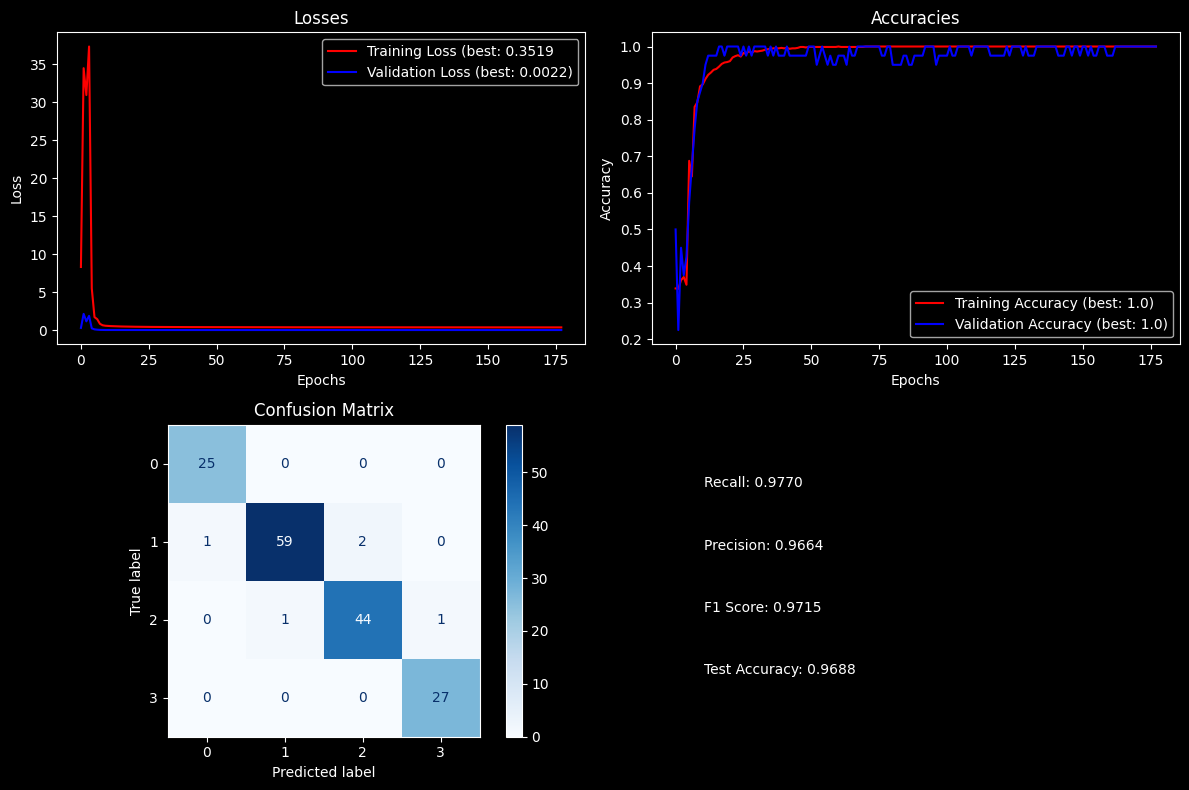

In [34]:
#set seed for reproducable results
np.random.seed(0)
epochs = 1000
lr = 0.15
keep_prob = 0.4
l2_lambda = 0.1
mod = Model(lr=lr, dropout_keep_rate=keep_prob, l2_reg=l2_lambda)
mod.add_layer(Dense_Layer(X_train.shape[1], 200))
mod.add_layer(relu())
mod.add_layer(Dense_Layer(200, 200))
mod.add_layer(relu())
mod.add_layer(Dense_Layer(200, 200))
mod.add_layer(relu())
mod.add_layer(Dense_Layer(200, Y_train_one_hot.shape[1]))
mod.add_layer(Softmax())
mod.set_loss("CELoss")
mod.fit(epochs=epochs, patience=85)
mod.plot_metrics(Y_pred=mod.predict(X_test), Y_true=Y_test)

Thats not bad, let's compare it to scikit's Logisitic Regression Model.

In [35]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
print(f"accuracy: {accuracy:.3f}\n")

accuracy: 0.975



## Final thoughts

I think given the dataset's size my model performed relatively well. However I think accuracy could be improved by either artifically expanding the dataset or using another algorithm like random forest

Additionally, I think maybe a different combination of hyperparameters and seed would yield better results